Theory of Computation Innovative Assignment:
NFA to RegEx

20BCE010, 20BCE054, 20BCE064

In [101]:
import pandas as pd
from visual_automata.fa.dfa import VisualDFA
from automata.fa.dfa import DFA

In [110]:
# define the NFA class
class NFA:
    def __init__(self, states, alphabet, transitions, start_state, accept_states):
        self.states = states
        self.alphabet = alphabet
        self.transitions = transitions
        self.start_state = start_state
        self.accept_states = accept_states

# function to read user input for NFA
def get_nfa_from_user():
    # read the number of states
    n = int(input("Enter the number of states: "))

    # read the set of states
    states = list(input(f"Enter the {n} states (comma-separated): ").split(","))

    # read the alphabet
    alphabet = list(input("Enter the alphabet (comma-separated): ").split(","))

    # read the transitions
    transitions = {}
    for state in states:
        for symbol in alphabet:
            target_states = set(input(f"Enter the states that {state} transitions to with {symbol} (comma-separated, empty if none): ").split(","))
            if target_states == {''}:
                print("empty found")
                transitions[(state, symbol)] = set()
            else:    
                transitions[(state, symbol)] = target_states

    # read the start state
    start_state = input("Enter the start state: ")

    # read the accept states
    accept_states = list(input("Enter the accept states (comma-separated): ").split(","))

    # create the NFA object
    nfa = NFA(states, alphabet, transitions, start_state, accept_states)

    return nfa

# function to convert NFA to DFA
def nfa_to_dfa(nfa):
    # initialize the DFA
    dfa_states = set()
    dfa_transitions = {}
    dfa_start_state = tuple([nfa.start_state])
    dfa_accept_states = set()

    # initialize the worklist with the start state
    worklist = [dfa_start_state]

    # process each state in the worklist
    while worklist:
        state = worklist.pop()
        dfa_states.add(state)

        # process each symbol in the alphabet
        for symbol in nfa.alphabet:
            target_states = set()

            # compute the set of states reachable from this state with this symbol
            for nfa_state in state:
                if (nfa_state, symbol) in nfa.transitions:
                    target_states.update(nfa.transitions[(nfa_state, symbol)])

            # if the set of target states is not empty, add it to the DFA
            if target_states:
                target_state = tuple(sorted(target_states))
                dfa_transitions[(state, symbol)] = target_state

                # if we haven't seen this target state before, add it to the worklist
                if target_state not in dfa_states:
                    worklist.append(target_state)

                # if the target state contains an accept state of the NFA, mark it as an accept state of the DFA
                if any(nfa_accept_state in target_states for nfa_accept_state in nfa.accept_states):
                    dfa_accept_states.add(target_state)

    # create the DFA object
    dfa = NFA(dfa_states, nfa.alphabet, dfa_transitions, dfa_start_state, dfa_accept_states)

    return dfa


def make_df(dfa):

    # Create the transition table as a dictionary of dictionaries
    transition_table = {}
    for state in dfa.states:
        state_name = "".join(state)
        transition_table[state_name] = {}
        for symbol in dfa.alphabet:
            target_state = dfa.transitions.get((state, symbol), None)
            if target_state is not None:
                target_state_name = "".join(target_state)
                transition_table[state_name][symbol] = target_state_name

    # Convert the transition table dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(transition_table, orient="index").fillna("-")

    # Set the column names to the alphabet symbols and sort them alphabetically
    df.columns = sorted(dfa.alphabet)

    # Rename the index column to "State" and sort the rows by state name
    df.index.name = "State"
    df = df.sort_index()

    # Adding deadstate
    # df = add_deadstate(df)

    # Print the resulting DataFrame
    return df

# Adding deadstate function
def add_deadstate(df):
    rows = df.index
    cols = df.columns
    is_dead = False

    for row in rows:
        for col in cols:
            if df.loc[row,col] == '-':
                is_dead = True
                df.loc[row,col] = 'DS'
    
    # Add another State - DS (Deadstate) if there are - transitions only
    if is_dead: 
        for col in cols:
            df.loc['DS',col] = 'DS'

    return df



# Convert States from tuples of states to a String ->  ('q1', 'q2') = 'q1q2'
def clean_state(states):
    temp = []
    for st in states:  # 'st' is a tuple
        state_string = ""
        for stat in st:
            state_string+=stat
        temp.append(state_string)
    return set(temp)

In [111]:
def show_dfa(dfa):
    # print the resulting DFA
    print("DFA:")
    print("States:", dfa.states)
    print("Alphabet:", dfa.alphabet)
    print("Transitions:")
    for transition, target_state in dfa.transitions.items():
        print(f"{transition[0]} --({transition[1]})--> {target_state}")
    print("Start state:", dfa.start_state)
    print("Accept states:", dfa.accept_states)


# Conversion function for VisualDFA library
def clean_transition (df):
    transitions = {}
    rows = df.index
    cols = df.columns
    for row in rows:
        tr = {}
        for col in cols:
            tr[col] = df.loc[row,col]

        transitions[row] = tr
    return transitions 


# Function for making State Diagram
def visual_dfa(dfa,transitions):
    viz = VisualDFA(
        states = set(df.index),
        input_symbols= set(dfa.alphabet),
        transitions= transitions,
        initial_state= dfa.start_state[0],
        final_states= set(clean_state(dfa.accept_states))
    )
    return viz


In [112]:
# Main function

def main():
    # Get the NFA from the user
    nfa = get_nfa_from_user()

    # Convert the NFA to a DFA
    dfa = nfa_to_dfa(nfa)
    
    # Make Dataframe for DFA 
    df = make_df(dfa)

    return (nfa,dfa,df)

In [113]:
(nfa,dfa,df) = main()

empty found


In [114]:
# Showing NFA
show_dfa(nfa)

DFA:
States: ['q0', 'q1', 'q2', 'q3']
Alphabet: ['0', '1']
Transitions:
q0 --(0)--> {'q3'}
q0 --(1)--> {'q1', 'q2'}
q1 --(0)--> {'q1', 'q3'}
q1 --(1)--> {'q1'}
q2 --(0)--> {'q3'}
q2 --(1)--> set()
q3 --(0)--> {'q3'}
q3 --(1)--> {'q3', 'q2'}
Start state: q0
Accept states: ['q3']


In [115]:
show_dfa(dfa)

DFA:
States: {('q1',), ('q1', 'q2'), ('q0',), ('q1', 'q2', 'q3'), ('q1', 'q3'), ('q3',), ('q2', 'q3')}
Alphabet: ['0', '1']
Transitions:
('q0',) --(0)--> ('q3',)
('q0',) --(1)--> ('q1', 'q2')
('q1', 'q2') --(0)--> ('q1', 'q3')
('q1', 'q2') --(1)--> ('q1',)
('q1',) --(0)--> ('q1', 'q3')
('q1',) --(1)--> ('q1',)
('q1', 'q3') --(0)--> ('q1', 'q3')
('q1', 'q3') --(1)--> ('q1', 'q2', 'q3')
('q1', 'q2', 'q3') --(0)--> ('q1', 'q3')
('q1', 'q2', 'q3') --(1)--> ('q1', 'q2', 'q3')
('q3',) --(0)--> ('q3',)
('q3',) --(1)--> ('q2', 'q3')
('q2', 'q3') --(0)--> ('q3',)
('q2', 'q3') --(1)--> ('q2', 'q3')
Start state: ('q0',)
Accept states: {('q1', 'q3'), ('q3',), ('q1', 'q2', 'q3'), ('q2', 'q3')}


In [116]:
# Transition Table (DataFrame)
df

,0,1
State,,
q0,q3,q1q2
q1,q1q3,q1
q1q2,q1q3,q1
q1q2q3,q1q3,q1q2q3
q1q3,q1q3,q1q2q3
q2q3,q3,q2q3
q3,q3,q2q3


In [117]:
# Check Memebership of a String


def check_membership(df, string ,start_state, accept_states):
    trn_table=pd.DataFrame(columns=['current_state','symbol','next_state'])
    
    
    prev = start_state
    j=0
    for alphabet in string:
        nxt=df.loc[prev,alphabet]
        trn_table.loc[len(trn_table.index)]=[prev,alphabet,nxt]
        prev=nxt

    if nxt in accept_states:
        return (True, trn_table)
    else:
        return (False, trn_table)


In [118]:
strng = "010101110"
mem_status, trans_table = check_membership(df, strng, dfa.start_state[0], clean_state(dfa.accept_states))

In [119]:
print("Membership Status : "+ str(mem_status))
print("Transitions : ")
print(trans_table)

Membership Status : True
Transitions : 
  current_state symbol next_state
0            q0      0         q3
1            q3      1       q2q3
2          q2q3      0         q3
3            q3      1       q2q3
4          q2q3      0         q3
5            q3      1       q2q3
6          q2q3      1       q2q3
7          q2q3      1       q2q3
8          q2q3      0         q3


In [120]:
viz = visual_dfa(dfa, clean_transition(df))

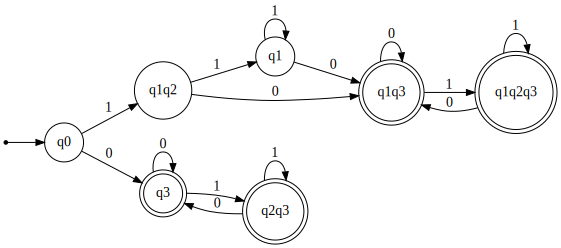

In [121]:
viz.show_diagram()

In [122]:
#REGEX conversion  State Elimination Method

# Add one initial state and one final state
def add_states_for_regex(dfa,df):
    initial_state = dfa.start_state[0]
    final_states = clean_state(dfa.accept_states)

    states = (list(df.index))
    intermediate_states = states.copy()
    states.insert(0,'Start')
    states.append('Final')

    return (states, initial_state, final_states, intermediate_states)

In [123]:
(states, initial_state, final_states, intermediate_states) = add_states_for_regex(dfa, df)

In [124]:
def make_matrix(df,states,initial_state,final_states):
    # Make Empty State-State Matrix
    matrix = [ [ '∅' for _ in states] for _ in states]
    matrix = pd.DataFrame(matrix, index = states, columns = states)
    
    # Fill matrix with present transitions
    for row in df.index:
        for col in df.columns:
            to = df.loc[row,col]
            if(matrix.loc[row,to] == '∅'):
                matrix.loc[row,to] = col
            else:
                matrix.loc[row,to] += "+"+col

    # Make links from new init state to old init state and final states
    matrix.loc['Start', initial_state] = 'ε'
    for finst in final_states:
        matrix.loc[finst,'Final'] = 'ε'

    initial_state = 'Start'
    final_state = 'Final' 

    return (matrix,initial_state,final_states)

In [125]:
(matrix,initial_state,final_states) = make_matrix( df, states, initial_state, final_states)
matrix

,Start,q0,q1,q1q2,q1q2q3,q1q3,q2q3,q3,Final
Start,∅,ε,∅,∅,∅,∅,∅,∅,∅
q0,∅,∅,∅,1,∅,∅,∅,0,∅
q1,∅,∅,1,∅,∅,0,∅,∅,∅
q1q2,∅,∅,1,∅,∅,0,∅,∅,∅
q1q2q3,∅,∅,∅,∅,1,0,∅,∅,ε
q1q3,∅,∅,∅,∅,1,0,∅,∅,ε
q2q3,∅,∅,∅,∅,∅,∅,1,0,ε
q3,∅,∅,∅,∅,∅,∅,1,0,ε
Final,∅,∅,∅,∅,∅,∅,∅,∅,∅


In [90]:
def loop_check(matrix, state):
    if (matrix.loc[state,state] == 'ε' or matrix.loc[state,state] == '∅'):
        return (False,'')
    return (True,matrix.loc[state,state])

def find_preds(matrix, state):
    pred_list =[]
    for row in matrix.columns:
        if(row == state ):
            continue
        if(matrix.loc[row,state]!='∅'):
            pred_list.append(row)

    return pred_list


def find_succ(matrix,state):
    succ_list =[]
    for col in matrix.columns:
        if(col == state ):
            continue
        if(matrix.loc[state, col ]!='∅'):
            succ_list.append(col)

    return succ_list

In [126]:
# State Elimination Method
def state_elim(matrix,intermediate_states):

    for interm in intermediate_states:
        is_loop,self_loop = loop_check(matrix=matrix, state=interm)

        preds = find_preds(matrix, interm)
        succs = find_succ(matrix, interm)
        print("State : "+ str(interm))
        print("Preds : "+ str(preds))
        print("Succs : "+ str(succs))

        for pred in preds:
            for succ in succs:
                if(matrix.loc[pred,succ] == '∅'):
                    # No transition from pred to succ
                    if is_loop: # Self loop check
                        matrix.loc[pred,succ]  = '.'.join(('('+matrix.loc[pred,interm]+')', '('+self_loop+")"+"*", '('+matrix.loc[interm,succ]+')'))
                    else:
                        matrix.loc[pred,succ]  = '.'.join(('('+matrix.loc[pred,interm]+')', '('+matrix.loc[interm,succ]+')'))
                else: # Transition already exist
                    if is_loop:
                        matrix.loc[pred,succ]  = '+'.join((matrix.loc[pred,succ],'.'.join(('('+matrix.loc[pred,interm]+')', '('+self_loop+")"+"*", '('+matrix.loc[interm,succ]+')'))))
                    else:
                        matrix.loc[pred,succ]  = '+'.join((matrix.loc[pred,succ],'.'.join(('('+matrix.loc[pred,interm]+')', '('+matrix.loc[interm,succ]+')'))))

        for pred in preds:
            matrix.loc[pred,interm] = '∅'
        for succ in succs:       
            matrix.loc[interm, succ] = '∅'
        matrix.loc[interm,interm] = '∅'
        print(matrix)
    return matrix


In [127]:
matrix=state_elim(matrix,intermediate_states)

regex = matrix.loc['Start','Final']

State : q0
Preds : ['Start']
Succs : ['q1q2', 'q3']
       Start q0 q1     q1q2 q1q2q3 q1q3 q2q3       q3 Final
Start      ∅  ∅  ∅  (ε).(1)      ∅    ∅    ∅  (ε).(0)     ∅
q0         ∅  ∅  ∅        ∅      ∅    ∅    ∅        ∅     ∅
q1         ∅  ∅  1        ∅      ∅    0    ∅        ∅     ∅
q1q2       ∅  ∅  1        ∅      ∅    0    ∅        ∅     ∅
q1q2q3     ∅  ∅  ∅        ∅      1    0    ∅        ∅     ε
q1q3       ∅  ∅  ∅        ∅      1    0    ∅        ∅     ε
q2q3       ∅  ∅  ∅        ∅      ∅    ∅    1        0     ε
q3         ∅  ∅  ∅        ∅      ∅    ∅    1        0     ε
Final      ∅  ∅  ∅        ∅      ∅    ∅    ∅        ∅     ∅
State : q1
Preds : ['q1q2']
Succs : ['q1q3']
       Start q0 q1     q1q2 q1q2q3            q1q3 q2q3       q3 Final
Start      ∅  ∅  ∅  (ε).(1)      ∅               ∅    ∅  (ε).(0)     ∅
q0         ∅  ∅  ∅        ∅      ∅               ∅    ∅        ∅     ∅
q1         ∅  ∅  ∅        ∅      ∅               ∅    ∅        ∅     ∅
q1q2       ∅  ∅  ∅ 

In [128]:
print("Regular expression for given NFA : "+regex)

Regular expression for given NFA : (((ε).(1)).(0+(1).(1)*.(0))).(0+(1).(1)*.(0))*.(ε+(1).(1)*.(ε))+((ε).(0)).(0+(1).(1)*.(0))*.(ε+(1).(1)*.(ε))
